In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
sys.path.append('../../..')
from src import fake_log, lighten
from scipy.optimize import curve_fit
%matplotlib widget

if not os.path.exists('Figs'):
    os.mkdir('Figs')

In [2]:
res = pd.read_csv('mass_measurements_titration.csv')
res_sample = res[res['measurement_type'] == 'Mw']

res_L109R = pd.read_csv('mass_measurements_L109R.csv')
res_L109R_sample = res_L109R[res_L109R['measurement_type'] == 'Mw']

### Model

In [3]:
def monomer(tot, wd):
    # Concentration of monomer molecules
    return 0.25 * np.exp(-wd) * (np.sqrt(8 * np.exp(wd) * tot + 1) - 1)

def dimer(tot, wd):
    # Concentration of dimer molecules
    return (tot - monomer(tot, wd)) / 2

# def mol_weight(tot, wd, mass=9.23474):
#     mon = monomer(tot, wd)
#     dim = dimer(tot, wd)
#     return ((mass * mon) + (2 * mass * dim)) / (mon + dim)

def mol_weight(tot, wd, mass=9.23474):
    # Weight average molecular weight (Mw)
    mon = monomer(tot, wd)
    dim = dimer(tot, wd)
    return (((mass ** 2) * mon) + (((2 * mass) ** 2) * dim)) / ((mass * mon) + (2 * mass * dim))

### For paper

In [4]:
def minor_ticks(ax, xrange=[-1, 2]):
    xlim = ax.get_xlim()
    minor_x_ticks = np.array([])
    for i in range(xrange[0], xrange[1]):
        a = np.log10(np.linspace(10 ** i, 10 ** (i + 1), 10))
        minor_x_ticks = np.append(minor_x_ticks, a)
    ax.set_xticks(minor_x_ticks, minor=True)
    ax.set_xlim(*xlim)

-0.46814259890557874


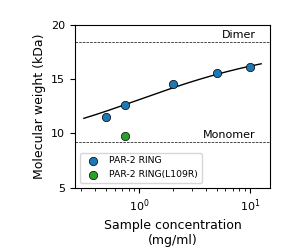

In [5]:
x = res_sample['input_concentration'] / 1000
y = res_sample['mass'] / 1000
sigma = 1 / (res_sample['uncertainty'] / 1000)

popt, pcov = curve_fit(lambda x, wd: mol_weight(x, wd, mass=9.23474), x, y, sigma=sigma, absolute_sigma=False)
print(popt[0])

fig, ax = plt.subplots()
ax.plot(np.linspace(-0.5, 1.1, 1000), mol_weight(10 ** np.linspace(-0.5, 1.1, 1000), popt[0]), c='k', zorder=-1,
       linewidth=1)

for x, y in zip(res_sample['input_concentration'] / 1000, res_sample['mass'] / 1000):
    ax.scatter(np.log10(x), y, linewidth=0.5, edgecolors='k', color=lighten('tab:blue', 1))

ax.scatter(np.log10(res_L109R_sample['input_concentration'] / 1000), 
           res_L109R_sample['mass'] / 1000, color=lighten('tab:green', 1), linewidth=0.5, edgecolors='k')
    
ax.set_ylim(5, 20)
ax.axhline(9.23474, c='k', linestyle='--', linewidth=0.5, zorder=0)
ax.axhline(9.23474 * 2, c='k', linestyle='--', linewidth=0.5, zorder=0)

ax.tick_params(axis='both', labelsize=8)
ax.set_xlabel('Sample concentration\n(mg/ml)', fontsize=9)
ax.set_ylabel('Molecular weight (kDa)', fontsize=9)

ax.text(1.05, 9.4, 'Monomer', horizontalalignment='right', verticalalignment='bottom', fontsize=8)
ax.text(1.05, 18.6, 'Dimer', horizontalalignment='right', verticalalignment='bottom', fontsize=8)

ax.set_xticks([0, 1])
ax.xaxis.set_major_formatter(fake_log)
minor_ticks(ax)

ax.scatter([], [], linewidth=0.5, edgecolors='k', color=lighten('tab:blue', 1), label='PAR-2 RING')
ax.scatter([], [], linewidth=0.5, edgecolors='k', color=lighten('tab:green', 1), label='PAR-2 RING(L109R)')
ax.legend(fontsize=6.7)
ax.set_yticks([5, 10, 15, 20])

fig.set_size_inches(3, 2.5)
fig.subplots_adjust(left=0.25, bottom=0.25, top=0.9)
fig.savefig('Figs/titration.png', dpi=600, transparent=True)